# Reproducing paper figures

In the interest of reproducibility, this notebook recreates all figures used in the PowerTech Paper.

In [1]:
using PyPlot

INFO: Loading help data...


In [5]:
readdir("../images")

6-element Array{Union(ASCIIString,UTF8String),1}:
 "Reigvec.png"  
 "Rkernel.png"  
 "scores.pdf"   
 "secular2.pdf" 
 "secular96.png"
 "secular.pdf"  

## Secular Equation

In [2]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")

using TemporalInstanton,TemporalInstanton2

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 0.5 # Heating constant
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
P0 = [0.5.*Rp,Rp,1.5*Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 0.03 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)];

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# For a single line:
line = lines[118]

# Create instance of instanton problem
Qobj,A,b,Qtheta = temporalInstanton(Ridx,Y,ref,k,tau,line,G0,P0,D0)
# Form obj and constraint quadratics:
G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

println("loaded")

# Partition A:
A1,A2,A3,idx1,idx2,idx3 = partition_A(A,Qobj,T)

# Find translation point:
x_star = find_x_star(Qobj,A,b,T)

# Translate quadratics:
G_of_y = translate_quadratic(G_of_x,x_star)
Q_of_y = translate_quadratic(Q_of_x,x_star)

N = kernel_rotation(A)[:,1:size(A,2) - rank(A)] # take only first k cols

N1,N2,N3 = N[idx1,:],N[idx2,:],N[idx3,:] # partition N

G_of_z = rotate_quadratic(G_of_y,N')
Q_of_z = rotate_quadratic(Q_of_y,N')

D,U = eig(Q_of_z[1])
D = round(D,10)

K = return_K(D)

G_of_w = rotate_quadratic(G_of_z,(U/K)')
Q_of_w = rotate_quadratic(Q_of_z,(U/K)')

B11,B12,B21,B22,b1,b2 = partition_B(G_of_w,Q_of_w)

Bhat,bhat = return_Bhat(B11,B12,B22,b1,b2)

loaded


(
3x3 Array{Float64,2}:
 411.686    0.0     -0.0  
   0.0    205.843   -0.0  
  -0.0     -0.0    102.921,

[34.3792,-32.9435,-29.3995])

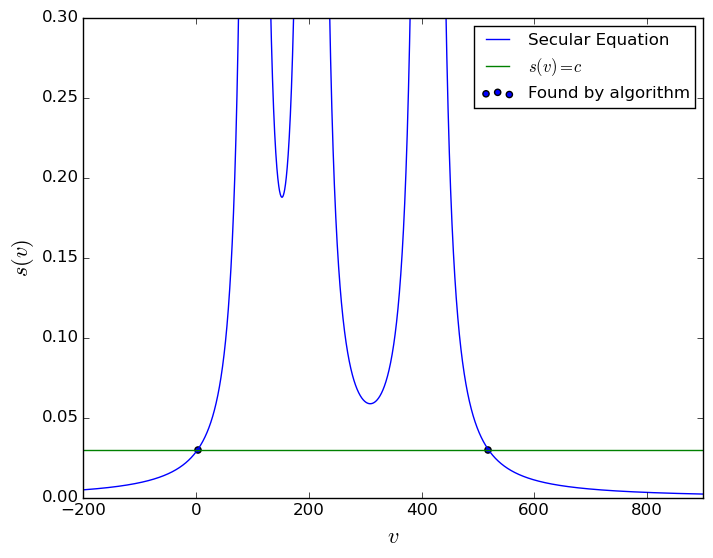

In [24]:
f = figure()
c = 0.03
poles = sort(unique(round(diag(Bhat),10)))

solutions,vectors = solve_secular(Bhat,bhat/2,c)

v_vals = linspace(minimum(poles)-8*minimum(poles),maximum(poles) + 4*maximum(poles),10000)
s_vals = [(find_w(i,Bhat,bhat/2)'*find_w(i,Bhat,bhat/2))[1] for i in v_vals]
plot(v_vals,s_vals)
hold = true
plot([v_vals[1],v_vals[end]],[c,c])
scatter(solutions,c*ones(length(solutions)))
legend(["Secular Equation",L"s(v) = c","Found by algorithm"],fontsize=12)
xlabel(L"v",fontsize=16)
ylabel(L"s(v)",fontsize=16)
axis([-200,900,0,0.3])

savefig("../images/secular.pdf")

## Sorted objective values

In [ ]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")

using TemporalInstanton,TemporalInstanton2

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 0.5 # Heating constant
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
P0 = [0.5.*Rp,Rp,1.5*Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 0.1 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)];

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# Create Qobj:
Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)

# Create A1 (only A2 changes during opt.):
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]

# Create b:
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)

# Create Qtheta:
Qtheta = tmp_inst_Qtheta(n,nr,T)#,tau)

# Form obj and constraint quadratics:
G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

println("loaded")

score,x,θ,α,diffs,xopt = loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines)

println("solved")

In [ ]:
plot(sort(score[score.<Inf]))
xlabel("Event Index",fontsize=16)
ylabel("Objective Value",fontsize=16)
#ylim([0,600])

#savefig("../images/scores.pdf")